# **1. Hiper parámetros, optimización y overfit**

## Entendiendo los parámetros

- **Hiperparámetros**: Valores que se pueden configurar inicialmente antes del entrenamiento
    - Métodos:
        - max_depth
        - GridSearchCV

> Necesarias nociones de Cross Validation

In [ ]:
import pandas as pd

datos = pd.read_csv("./data/carros.csv")
datos.head()

In [ ]:
#situacion con los datos ordenados de la peor manera
datos_ord = datos.sort_values("vendido", ascending=True)
x_ord = datos_ord[["precio", "edad_del_modelo","km_by_year"]]
y_ord = datos_ord["vendido"]
datos_ord.head()

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_ord, y_ord, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desviacion_estandar = results['test_score'].std()
print("Accuracy con dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desviacion_estandar)*100, (media + 2 * desviacion_estandar) * 100))

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_ord, y_ord, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desviacion_estandar = results['test_score'].std()
print("Accuracy con cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desviacion_estandar)*100, (media + 2 * desviacion_estandar) * 100))

In [ ]:
#generando datos aleatorios del modelo de carro
np.random.seed(SEED)
datos['modelo'] = datos.edad_del_modelo + np.random.randint(-2, 3, size=10000)
datos.modelo = datos.modelo + abs(datos.modelo.min()) + 1
datos.head()

In [ ]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desviacion = results['test_score'].std() * 100
  print("Accuracy media %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desviacion, media + 2 * desviacion))

In [ ]:
# GroupKFold para analizar como el modelo se comporta con nuevos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

In [ ]:
# GroupKFold en un pipeline con StandardScaler y SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacion',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

## Los parámetros

In [ ]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

In [ ]:
modelo

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_ord, y_ord)
features = x_ord.columns
dot_data = export_graphviz(modelo, out_file = None, filled = True, rounded = True, class_names = ['No','Sí'], feature_names = features)

graph = graphviz.Source(dot_data)
graph

In [ ]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_ord, y_ord)
features = x_ord.columns
dot_data = export_graphviz(modelo, out_file = None, filled = True, rounded = True, class_names = ['No','Sí'], feature_names = features)

graph = graphviz.Source(dot_data)
graph

In [ ]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
# No por aumentar el valor de max_depth aumenta la precisión del modelo
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
imprime_resultados(results)

## ¿Cuanto más complejo el árbol, mejor?


In [ ]:
def iniciar_arbol_de_decision(max_depth):
    SEED = 301
    np.random.seed(SEED)
    
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=False)
    test_score = results['test_score'].mean()*100
    print('Árbol max_depth = %d, testing = %.2f' % (max_depth, test_score))

for i in range(1,33):
    iniciar_arbol_de_decision(i)

### Optimización de un hiper parámetro y el problema de overfit


In [ ]:
def iniciar_arbol_de_decision(max_depth):
    SEED = 301
    np.random.seed(SEED)
    
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=True)
    test_score = results['test_score'].mean()*100
    train_score = results['train_score'].mean()*100
    print('Árbol max_depth = %d, training = %.2f, testing = %.2f' % (max_depth, train_score, test_score))
    tabla = [max_depth, train_score, test_score]
    return tabla

resultados = [iniciar_arbol_de_decision(i) for i in range(1,33)]
resultados = pd.DataFrame(resultados, columns = ['max_depth', 'train', 'test'])
resultados.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(x = 'max_depth', y = 'train', data = resultados);
sns.lineplot(x = 'max_depth', y = 'test', data = resultados);
plt.legend(['Train','Test']);

In [ ]:
resultados.sort_values('test', ascending = False).head()

# **2. Explorando 2 Dimensiones de hiper parámetros**

## Explorando hiper parámetros de más dimensiones



In [ ]:
def iniciar_arbol_de_decision(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)
    
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=True)
    test_score = results['test_score'].mean()*100
    train_score = results['train_score'].mean()*100
    print('Árbol max_depth = %d, min_samples_leaf = %d, training = %.2f, testing = %.2f' % (max_depth, min_samples_leaf, train_score, test_score))
    tabla = [max_depth, min_samples_leaf, train_score, test_score]
    return tabla

def buscar():
    resultados = []
    for max_depth in range(1,32):
        for min_samples_leaf in [32, 64, 128, 256]:
            tabla = iniciar_arbol_de_decision(max_depth, min_samples_leaf)
            resultados.append(tabla)
    resultados = pd.DataFrame(resultados, columns = ['max_depth', 'min_samples_leaf', 'train', 'test'])
    return resultados

resultados = buscar()
resultados.head()

In [ ]:
resultados.sort_values('test', ascending = False).head()

## Matriz de correlación y explorando más espacios de parámetros

In [ ]:
corr = resultados.corr()
corr

In [ ]:
sns.heatmap(corr);

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(resultados, figsize = (14,8), alpha = 0.3);

In [ ]:
sns.pairplot(resultados);

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
def buscar():
    resultados = []
    for max_depth in range(1,10):
        for min_samples_leaf in [128, 190, 220, 256]:
            tabla = iniciar_arbol_de_decision(max_depth, min_samples_leaf)
            resultados.append(tabla)
    resultados = pd.DataFrame(resultados, columns = ['max_depth', 'min_samples_leaf', 'train', 'test'])
    return resultados

resultados = buscar()
resultados.head()

In [ ]:
resultados.sort_values('test', ascending = False).head()

# **3. Trabajando con 3 o más dimensiones**

## Explorando 3 ó más hiper parámetros

In [31]:
def iniciar_arbol_de_decision(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)
    
    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    results = cross_validate(modelo, x_ord, y_ord, cv = cv, groups = datos.modelo, return_train_score=True)
    test_score = results['test_score'].mean()*100
    train_score = results['train_score'].mean()*100
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    print('Árbol max_depth = %d, min_samples_leaf = %d, min_samples_split = %d, training = %.2f, testing = %.2f' % (max_depth, min_samples_leaf, min_samples_split, train_score, test_score))
    tabla = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
    return tabla

def buscar():
    resultados = []
    for max_depth in range(1,32):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                tabla = iniciar_arbol_de_decision(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabla)
    resultados = pd.DataFrame(resultados, columns = ['max_depth', 'min_samples_leaf', 'min_samples_split', 'train', 'test', 'fit_time', 'score_time'])
    return resultados

resultados = buscar()
resultados.head()

Árbol max_depth = 1, min_samples_leaf = 32, min_samples_split = 32, training = 75.79, testing = 75.78
Árbol max_depth = 1, min_samples_leaf = 32, min_samples_split = 64, training = 75.79, testing = 75.78
Árbol max_depth = 1, min_samples_leaf = 32, min_samples_split = 128, training = 75.79, testing = 75.78
Árbol max_depth = 1, min_samples_leaf = 32, min_samples_split = 256, training = 75.79, testing = 75.78
Árbol max_depth = 1, min_samples_leaf = 64, min_samples_split = 32, training = 75.79, testing = 75.78
Árbol max_depth = 1, min_samples_leaf = 64, min_samples_split = 64, training = 75.79, testing = 75.78
Árbol max_depth = 1, min_samples_leaf = 64, min_samples_split = 128, training = 75.79, testing = 75.78
Árbol max_depth = 1, min_samples_leaf = 64, min_samples_split = 256, training = 75.79, testing = 75.78
Árbol max_depth = 1, min_samples_leaf = 128, min_samples_split = 32, training = 75.79, testing = 75.78
Árbol max_depth = 1, min_samples_leaf = 128, min_samples_split = 64, training

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.018522,0.004512
1,1,32,64,75.791169,75.784219,0.010949,0.002302
2,1,32,128,75.791169,75.784219,0.011880,0.002703
3,1,32,256,75.791169,75.784219,0.010465,0.002003
4,1,64,32,75.791169,75.784219,0.010975,0.002520


In [32]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
max_depth,1.000000e+00,1.642886e-16,3.990718e-16,0.538343,0.015135,0.553161,-0.039964
min_samples_leaf,1.642886e-16,1.000000e+00,9.965536e-19,-0.334243,0.280463,-0.542302,0.038230
min_samples_split,3.990718e-16,9.965536e-19,1.000000e+00,-0.123452,0.130175,-0.049903,0.048498
train,5.383434e-01,-3.342432e-01,-1.234515e-01,1.000000,0.263804,0.873845,-0.021307
test,1.513479e-02,2.804627e-01,1.301748e-01,0.263804,1.000000,-0.052441,0.014702
fit_time,5.531614e-01,-5.423023e-01,-4.990314e-02,0.873845,-0.052441,1.000000,-0.040145
score_time,-3.996415e-02,3.823004e-02,4.849761e-02,-0.021307,0.014702,-0.040145,1.000000


<Axes: >

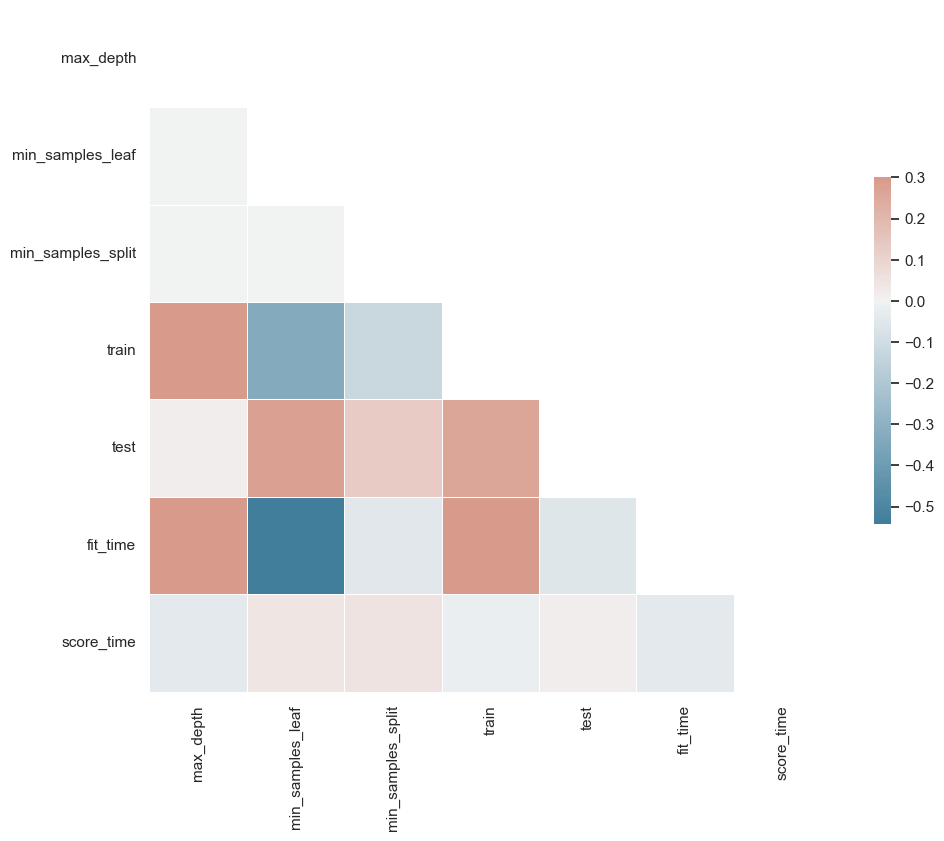

In [33]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [35]:
resultados.sort_values('test', ascending = False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
45,3,256,64,78.750993,78.672633,0.022578,0.002315
41,3,128,64,78.750993,78.672633,0.022614,0.002838
48,4,32,32,78.750993,78.672633,0.031329,0.003101
47,3,256,256,78.750993,78.672633,0.024192,0.002642
46,3,256,128,78.750993,78.672633,0.022191,0.002421


# **4. Búsqueda de hiper parámetros con GridSearchCV**

## Utilizando GridSearchCV

In [38]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

espacio_de_parametros = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'criterion': ['gini', 'entropy']
}

buscar = GridSearchCV(DecisionTreeClassifier(),
                      espacio_de_parametros,
                      cv = GroupKFold(n_splits = 10))

buscar.fit(x_ord, y_ord, groups = datos.modelo)

resultados = pd.DataFrame(buscar.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.029530,0.008678,0.002876,0.001446,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.023520,0.001108,0.002416,0.000507,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.022548,0.000459,0.002226,0.000450,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.023187,0.000764,0.002571,0.000601,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.023185,0.000776,0.002331,0.000510,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [41]:
print(buscar.best_params_)
print(buscar.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [42]:
mejor = buscar.best_estimator_
mejor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [46]:
from sklearn.metrics import accuracy_score

# Escenario Optimista
prediccion = mejor.predict(x_ord)
accuracy = accuracy_score(prediccion, y_ord) * 100

print('Accuracy para los datos fue %.2f%%' % accuracy)

Accuracy para los datos fue 78.75%


# **5. Nested Cross Validation y validando el modelo elegido**

> La documentación indica que se utiliza GridSearchCV para la optimización mediante hipeparámetros es necesario realizar nuevamente una nueva validación cruzado el modelo propuesto sobre los resultados obtenidos.

In [47]:
from sklearn.model_selection import KFold

SEED = 301
np.random.seed(SEED)

espacio_de_parametros = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'criterion': ['gini', 'entropy']
}

buscar = GridSearchCV(DecisionTreeClassifier(),
                      espacio_de_parametros,
                      cv = KFold(n_splits = 5, shuffle = True))

buscar.fit(x_ord, y_ord)

resultados = pd.DataFrame(buscar.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.034300,0.010010,0.003002,0.000631,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.023496,0.003513,0.002750,0.000669,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.022855,0.001716,0.002400,0.000489,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.023019,0.000737,0.003402,0.001359,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.023470,0.001538,0.003607,0.000800,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [49]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(buscar, x_ord, y_ord, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [51]:
def imprime_score(scores):
    media = scores.mean() * 100
    desviacion = scores.std() * 100
    print("Accuracy media %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desviacion, media + 2 * desviacion))

imprime_score(scores)

Accuracy media 78.67
Intervalo [76.80, 80.54]


In [52]:
mejor = buscar.best_estimator_
mejor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

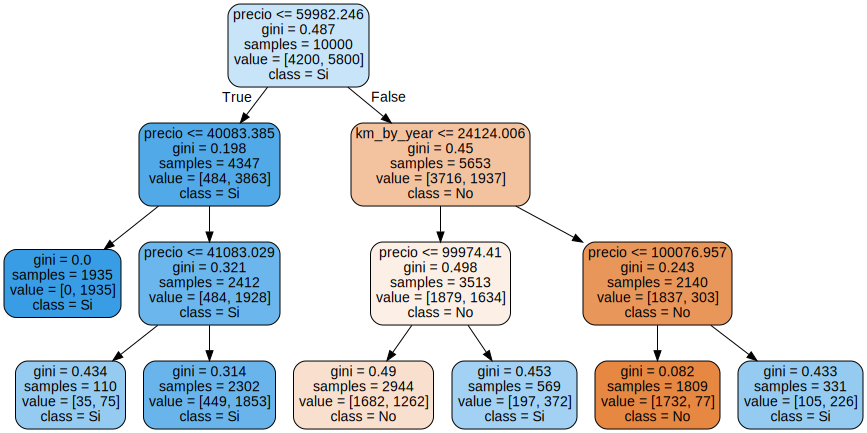

In [53]:
features = x_ord.columns
dot_data = export_graphviz(mejor, out_file=None, filled=True, rounded=True, class_names=['No', 'Si'], feature_names=features)

graph = graphviz.Source(dot_data)
graph